# SORA - Stellar Occultation Reduction and Analysis

## LightCurve Object Class

The LightCurve Object Class within SORA was created to reduce and analyze stellar occultations' light curves. Here we present some useful tasks that allows the user:
- set the model's parameters
- prepare the light curve to be reduced
- fit one or all parameters simultaneously.

The documentation at <font color=blue>add link</font> contains the details about every step.  

This Jupyter-Notebook was designed as a tutorial for how to work with the LightCurve Object Class. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.

### Index

1. [Instantiating the LightCurve Object](#section_1)

2. [Set and/or modify model parameters](#section_2)

3. [Preparing the LightCurve](#section_3)

    3.1 [Light curve normalization using a polinomial fit](#section_3a)


4. [Automatic dettection of Occultations](#section_4)

5. [Complete occultation light curve model and fitting](#section_5)

    5.1 [Automatic mode](#section_5a)
    
    5.2 [Fitting only the immersion](#section_5b)
    
    5.3 [Fitting the times and the opacity](#section_5c)


6. [Viewing and saving the results](#section_6)

In [1]:
## SORA package
from sora import LightCurve

## Other main and necessary packages
from astropy.time import Time
import astropy.units as u
import numpy as np
import matplotlib.pylab as pl
import os

<a id="section_1"></a>
### 1. Instantiating the LightCurve Object

The LightCurve Object Class can be instantiated in different ways.

First, all LightCurves Objects should have a 'name' that will distinguish it from other LightCurves Objects and also allows the Occultation Object to control all the steps and Objects. It is not possible to add two LightCurves Objects with the same name, although the user can add the same light curve file with different LightCurve Object names.

The LightCurve main goal is to reduce and analyse stellar occultations light curves, which is a file composed of two or three columns: time, flux, and flux uncertainty. An ASCII file can be used as input, where the first column is the time (Julian Date or seconds relative to a reference time), the second column is the flux for each time, and the third is the flux uncertainty (optional). Another option is to furnish theses parameters directly as NumPy arrays. If the time provided is in JD the reference time will be set as 00:00:00.000 of the occultation date, otherwise the user should add the used reference time.

Other observational parameters needed are the exposure time for the respective light curve (in seconds) and the filter parameters (central wavelength and bandwidth, in microns). If the filter parameter is not furnished the default values are used: $\lambda_0$ as 0.7 and $\Delta \lambda$ as 0.3 microns.

If the parameters of the light curve were already calculated using SORA or other method, the user could instantiate the LightCurve by only providing the instants of immersion and emersion and their uncertainties, with no need to provide a light curve file. This is useful for example in cases where the user does not want to redo the fitting process and go directly to the chords and ellipse fit procedure within the Occultation Object Class.

The user can also instantiate a LightCurve Object for the negative observations. In this case, it is just needed the initial and the end time of the observational sequence. In this case, an Error (and a warning message) will raise for all functions in this module that require times and fluxes, but the object will be instantiated and can be used for other purposes.

**The LightCurve Docstring was designed to help the users. Also, each function has its Docstring containing its main purpose and the needed parameters to set (physical description and formats). Please, do not hesitate to use it.**

In [2]:
LightCurve?

**Example of LightCurve intantiate with an ASCII file**

In [3]:
# The file lc_example.dat contains time in JD and flux
lc_1a = LightCurve(name='Example 1a',file='input/lightcurves/lc_example.dat',exptime=0.100)

In [4]:
# The file lc_example_trend.dat contains time in seconds and flux, so it is needed a reference time
lc_1b = LightCurve(name='Example 1b',file='input/lightcurves/lc_example_trend.dat',tref=Time('2017-06-22 00:00'),exptime=0.100)

**Example of LightCurve intantiate with NumPy arrays with times as Julian Dates**

In [5]:
time, flux = np.loadtxt('input/lightcurves/lc_example_2.dat',unpack=True)

print('first time: ',time[0])

lc_2a = LightCurve(name='Example 2a',time=time,flux=flux,exptime=0.075)

first time:  2457927.38872249


**Example of LightCurve intantiate with NumPy arrays with times as seconds relative to a reference time**

In [6]:
time, flux = np.loadtxt('input/lightcurves/lc_example_2.dat',unpack=True)

tref = Time('2017-06-22 21:00').jd

time_sec = (time - tref)*u.d.to(u.s)

print('first time: ',time_sec[0])

lc_2b = LightCurve(name='Example 2b',time=time_sec,flux=flux,tref=Time('2017-06-22 21:00'),exptime=0.075)

first time:  1185.6231406331062


**Example of LightCurve intantiate with the required parameters (positive)**

In [7]:
lc_3 = LightCurve(name='Example 3',
                  initial_time=Time('2017-06-22 21:16:00.094'),
                  end_time =Time('2017-06-22 21:28:00.018'),
                  immersion=Time('2017-06-22 21:21:15.628'),immersion_err=0.010,
                  emersion =Time('2017-06-22 21:21:19.988'),emersion_err=0.040)


**Example of LightCurve intantiate with the required parameters (negative)**

In [8]:
lc_4 = LightCurve(name='Example 4',
                  initial_time=Time('2017-06-22 21:16:00.094'),
                  end_time =Time('2017-06-22 21:28:00.018'))


**An error will rise if the user try to intanciate two LightCurves with the same name**

In [9]:
lc_5a = LightCurve(name='Example 5',
                   initial_time=Time('2017-06-22 21:16:00.094'),
                   end_time =Time('2017-06-22 21:28:00.018'))

lc_5b = LightCurve(name='Example 5',
                   initial_time=Time('2017-06-22 20:00:00'),
                   end_time =Time('2017-06-22 21:30:00'))

ValueError: name Example 5 already defined for another LightCurve object. Please choose a different one.

**If the user wants to overwrite the previous LightCurve, first they need to delete it**

In [10]:
del(lc_5a)

lc_5b = LightCurve(name='Example 5',
                   initial_time=Time('2017-06-22 20:00:00'),
                   end_time =Time('2017-06-22 21:30:00'))


**After the LightCurve was instantiated, some parameters can be easily retrieved**

In [11]:
print('Name: {}'.format(lc_1a.name))
print('Initial time: {} UTC'.format(lc_1a.initial_time.iso))
print('End time:     {} UTC'.format(lc_1a.end_time.iso))

Name: Example 1a
Initial time: 2017-06-22 21:20:00.056 UTC
End time:     2017-06-22 21:23:19.958 UTC


**If the LightCurve  were instantiated with times and fluxes, the exposure time and the mean cycle can also be obtained**

In [12]:
print('Exposure time: {:.4f} s'.format(lc_1a.exptime))
print('Cycle time:    {:.4f} s'.format(lc_1a.cycle))

Exposure time: 0.1000 s
Cycle time:    0.1002 s


<a id="section_2"></a>
### 2. Set and/or modifing model parameters

In order to create a stellar occultation light curve model, some physical parameters are needed. First, we need to 'project' the time axis of the light curve in the sky plane using the event's velocity ($vel$ in km/s). Then the Fresnel diffraction should be applied. That diffraction works in a scale that depends on the object distance ($dist$ in AU) and the observational wavelength ($\lambda_0$ and $\Delta \lambda$, in microns). The last parameter needed is the occulted star apparent diameter at the object distance ($d\_star$ in km). In all cases, the user can provide each parameter with its own unit, otherwise SORA will consider the standard units described above.

**Let's start with the shadow velocity during the occultation, in km/s**

In [13]:
lc_1a.set_vel(vel=22.0)
print('Vel: {:3.1f} km/s'.format(lc_1a.vel))

lc_1b.set_vel(vel=22.0*u.km/u.s)
print('Vel: {:3.1f} km/s'.format(lc_1b.vel))

lc_2a.set_vel(vel=22000.0*u.m/u.s)
print('Vel: {:3.1f} km/s'.format(lc_2a.vel))

Vel: 22.0 km/s
Vel: 22.0 km/s
Vel: 22.0 km/s


In [14]:
15*u.au.to('km')

2243968060.5

**Now, the object distance at occultation time, in AU**

In [15]:
lc_1a.set_dist(dist=15)
print('Distance: {:3.1f} AU'.format(lc_1a.dist))

lc_1b.set_dist(dist=15*u.AU)
print('Distance: {:3.1f} AU'.format(lc_1b.dist))

lc_2a.set_dist(dist=2243968060.5*u.km)
print('Distance: {:3.1f} AU'.format(lc_2a.dist))

Distance: 15.0 AU
Distance: 15.0 AU
Distance: 15.0 AU


**And then, the observational wavelength, central value ($\lambda_0$) and its bandwidth ($\Delta\lambda$), in microns**

Default value set as $\lambda_0$ = 0.7 and $\Delta\lambda$ = 0.3 microns, no filter (Clear).

In [16]:
print('Observational wavelength centred at {:1.3f} with a bandwidth of {:1.3f} microns'
      .format(lc_1a.lambda_0,lc_1a.delta_lambda))

lc_1b.set_filter(lambda_0=0.8, delta_lambda=0.2)
print('Observational wavelength centred at {:1.3f} with a bandwidth of {:1.3f} microns'
      .format(lc_1b.lambda_0,lc_1b.delta_lambda))

lc_2a.set_filter(lambda_0=0.8*u.micrometer, delta_lambda=0.2*u.micrometer)
print('Observational wavelength centred at {:1.3f} with a bandwidth of {:1.3f} microns'
      .format(lc_2a.lambda_0,lc_2a.delta_lambda))

lc_4.set_filter(lambda_0=800*u.nm, delta_lambda=200*u.nm)
print('Observational wavelength centred at {:1.3f} with a bandwidth of {:1.3f} microns'
      .format(lc_4.lambda_0,lc_4.delta_lambda))

Observational wavelength centred at 0.700 with a bandwidth of 0.300 microns
Observational wavelength centred at 0.800 with a bandwidth of 0.200 microns
Observational wavelength centred at 0.800 with a bandwidth of 0.200 microns
Observational wavelength centred at 0.800 with a bandwidth of 0.200 microns


**With the model parameters, the mean Fresnel Scale ($F_S$) is automatically calculated.**

$F_S = \frac{1}{2}.\left(\sqrt{\frac{(\lambda + 0.5.\Delta\lambda).dist}{2}} + \sqrt{\frac{(\lambda - 0.5.\Delta\lambda).dist}{2}}\right)$

In [17]:
print('Fresnel Scale: {:1.3f} km'.format(lc_1a.fresnel_scale))

Fresnel Scale: 0.881 km


**Last, let's set the stellar diameter projected at the body distance, in km**

In [18]:
lc_1a.set_star_diam(d_star=0.2)
print('Stellar diameter: {:1.2f} km'.format(lc_1a.d_star))

lc_1b.set_star_diam(d_star=0.2*u.km)
print('Stellar diameter: {:1.2f} km'.format(lc_1b.d_star))

lc_2a.set_star_diam(d_star=200*u.m)
print('Stellar diameter: {:1.2f} km'.format(lc_2a.d_star))

Stellar diameter: 0.20 km
Stellar diameter: 0.20 km
Stellar diameter: 0.20 km


**If the user instantiated the LightCurve Object without times and flux and wanna do it later (or redo it)**

In [20]:
lc_4.set_flux(file='input/lightcurves/lc_example_3.dat',exptime=0.32, tref='2018-05-20 00:00:00.000')

<a id="section_3"></a>
### 3. Preparing the LightCurve

With the LightCurve Object instantiated, the user may want to improve the quality of his curve using some processes.

For SORA v0.1 the only process implemented is the normalization of a light curve using a polinomial fit.

Other processes will be developed for future use, such as the binning of the light curve (sum, mean and median), a Savitzky–Golay filter, among others.

**First, let's check the expected magnitude drop and bottom flux**

In [21]:
lc_1b.calc_magnitude_drop(mag_obj=18.6,mag_star=14.3)

print('Expected magnitude drop: {:.3f}'.format(lc_1b.mag_drop))
print('Expected bottom flux:    {:.3f}'.format(lc_1b.bottom_flux))


Expected magnitude drop: 4.320
Expected bottom flux:    0.019


**Now, let's look at this light curve**

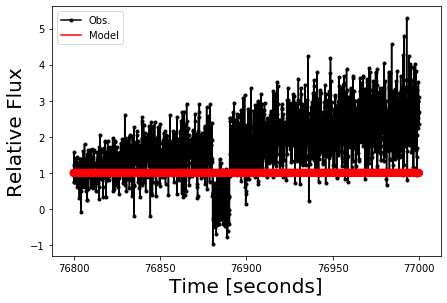

In [22]:
lc_1b.plot_lc()

**There is a linear trend at this light curve.** 

<a id="section_3a"></a>
#### 3.1. Light curve normalization using a polinomial fit


The user can remove this linear trend using the function LightCurve.normalize(). That function can be used automatically or with the desired inputed parameters.

In [23]:
lc_1b.normalize?

**Let's try the automatic mode**

/home/morgado/miniconda3/lib/python3.7/site-packages/scipy/odr/odrpack.py:860: OdrWarning: Empty data detected for ODR instance. Do not expect any fitting to occur
  OdrWarning)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Normalization using a 0 degree polynom
There is no improvement with a 1 degree polynom


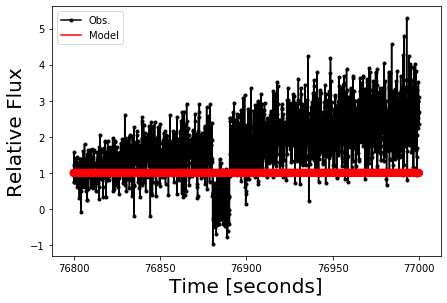

In [24]:
lc_1b.normalize()
lc_1b.plot_lc()

**If the user wants to see the steps inside the automatic mode, just set the $plot$ parameter as <font color=green>True</font>**

/home/morgado/miniconda3/lib/python3.7/site-packages/scipy/odr/odrpack.py:860: OdrWarning: Empty data detected for ODR instance. Do not expect any fitting to occur
  OdrWarning)


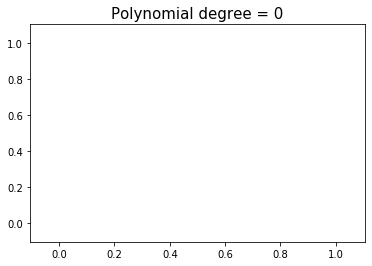

/home/morgado/miniconda3/lib/python3.7/site-packages/scipy/odr/odrpack.py:860: OdrWarning: Empty data detected for ODR instance. Do not expect any fitting to occur
  OdrWarning)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/morgado/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Normalization using a 0 degree polynom
There is no improvement with a 1 degree polynom


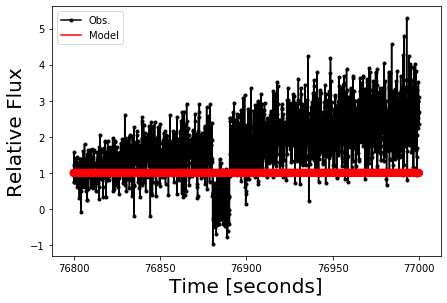

In [25]:
lc_1b.normalize(plot=True)
lc_1b.plot_lc()

**As an standard procedure within the SORA package the user can control all the parameters**

This is useful when the automatic mode does not work correctly (particular cases), or for better control of the procedure. 

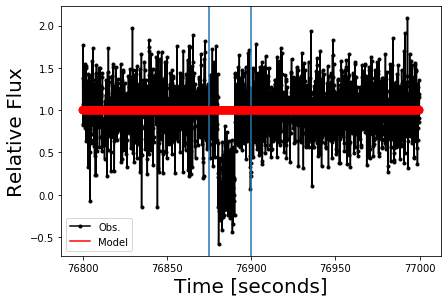

In [26]:
mask = (lc_1b.time < 76875) + (lc_1b.time > 76900) 
lc_1b.normalize(poly_deg=5,mask=mask)

lc_1b.plot_lc()
pl.axvline(76875)
pl.axvline(76900)
pl.show()

**Also, the user can control the maximum and/or minimum value of the flux**

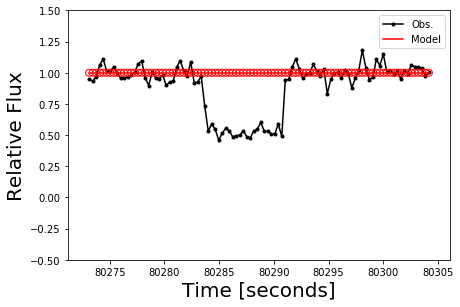

In [27]:
lc_4.plot_lc()
pl.ylim(-0.5,1.5)
pl.show()

**In this case the bottom flux goes to 0.5, instead of the expected 0.0. This com be solved setting the $flux\_min$ parameter**

Normalization using a 0 degree polynom
There is no improvement with a 1 degree polynom


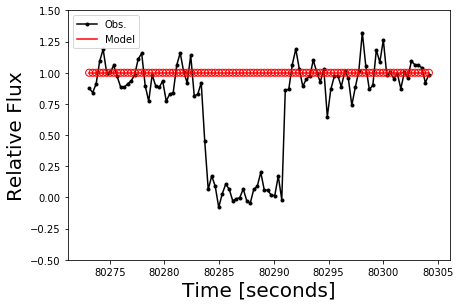

In [28]:
lc_4.normalize(flux_min=0.50)

lc_4.plot_lc()
pl.ylim(-0.5,1.5)
pl.show()

**If the user is not satisfied with the normalization, it is possible to throw away and redo the normalization process and to return to the initial stage using the LightCurve.reset_flux()**

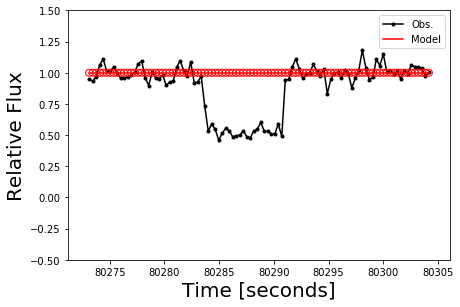

In [29]:
lc_4.reset_flux()

lc_4.plot_lc()
pl.ylim(-0.5,1.5)
pl.show()

<a id="section_4"></a>
### 4. Automatic detection of Occultations

Before considering any effect (Fresnell scale, star diameter, etc), the user can choose that SORA detect the events in the light curve automatically. This process is done using the BLS algorithm (<font color=blue>Kovacs et al., 2002</font>). This function will always find events and give their Signal to Noise Raito (SNR). The user will consider the values for the events found and determine the significance of each event. This is a useful tool for detection of low depth events or to check for secondary events, for example.

The result of the _LightCurve.occ_detect()_ will be a python dictionary containing: a rank for the detection; duration; central, immersion and emersion times; time uncertainty; flux depth and its uncertainty; baseline flux and its uncertainty; SNR; and a bollean mask with the values inside the detection. All the times are in seconds. The automatic mode will determine only one detection (the most significant).

In [30]:
lc_2a.occ_detect?

**For visual aid the user can set the $plot$ parameter as <font color=green>True</font>**

{'rank': 1,
 'occultation_duration': 11.52958944439888,
 'central_time': 76888.023570925,
 'immersion_time': 76882.2587762028,
 'emersion_time': 76893.7883656472,
 'time_err': 0.04017278552055359,
 'depth': 0.9797601789722584,
 'depth_err': 0.06536566413075075,
 'baseline': 1.0271920160757066,
 'baseline_err': 0.11532581974159437,
 'snr': 14.988911869883966,
 'occ_mask': array([False, False, False, ..., False, False, False])}

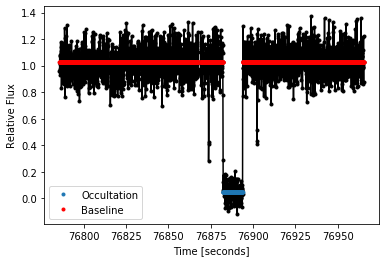

In [31]:
preliminary = lc_2a.occ_detect(plot=True)
preliminary

**The user can choose to detect more than one event, two parameters can be used to control this $n\_detections$ and $snr\_limit$**

With the $n\_detections$, the user will set the number of detections they want. On the other hand $snr\_limit$ will obtain all the detection within the set limit. In all cases is up to the user to confirm if these detections have physical meaning.

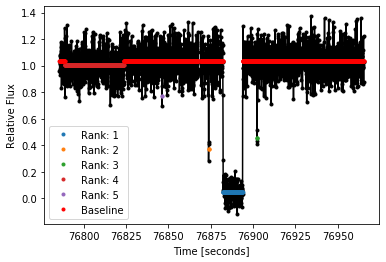

In [32]:
preliminary = lc_2a.occ_detect(n_detections=5, plot=True)

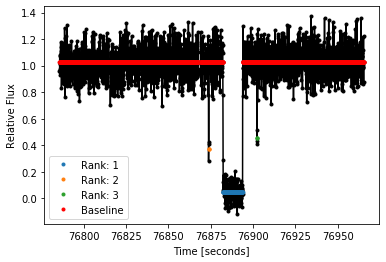

In [33]:
preliminary = lc_2a.occ_detect(snr_limit=5, plot=True)

**Other two parameters can be used for otimization purpose**

The first is the $maximum\_duration$, and this will set an upper limit to the size of the occultation (in seconds). The user can also set the $dur\_step$, which is the step size in seconds of the occultation search. Those parameters will decrease the CPU time of these searches.

{'rank': 1,
 'occultation_duration': 11.0,
 'central_time': 76888.3231406331,
 'immersion_time': 76882.8231406331,
 'emersion_time': 76893.8231406331,
 'time_err': 0.04017278552055359,
 'depth': 0.9802503938156636,
 'depth_err': 0.062074094327636595,
 'baseline': 1.0241496004823303,
 'baseline_err': 0.1266541830883394,
 'snr': 15.791618136895426,
 'occ_mask': array([False, False, False, ..., False, False, False])}

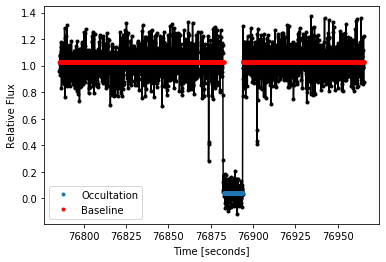

In [34]:
preliminary = lc_2a.occ_detect(maximum_duration=12,dur_step=1, plot=True)
preliminary

<a id="section_5"></a>
### 5. Complete occultation light curve model and fitting

The model considers a sharp-edge occultation model (geometric) convolved with Fresnel diffraction, stellar diameter (projected at the body distance), CCD bandwidth, and finite integration time. It is created using a smaller time resolution than the observational light curve. By default, the model will have a resolution that is 1/10 of the mean Fresnel Scale (in km) divided by the event's velocity (in km/s), if the exposure time is shorter than this value the software will use 1/10 of the exposure time. The parameters of interest are, mostly, the immersion and emersion times. Moreover, the opacity of the object can also be of interest for particular cases (occultations by rings, for instance), where 1.0 means an opaque body and 0.0 a transparent one.

The fit consists into create models and compare them with the observational light curve, through a standard $\chi^2$ test. The parameters that minimizes the $\chi^2$ are the fitted parameters and their uncertainties are obtained from the values within $1\sigma = \chi^2_{min} + 1$ and $3\sigma = \chi^2_{min} + 9$. The result of the fit is a ChiSquare Object Class, and its functions can be found at its specific Jupyter-Notebook.


In [35]:
lc_1a.occ_model?

**Let's find some parameters to create the model**

In [36]:
immersion_time = 76880.000  # seconds relative to tref
emersion_time  = 76891.000  # seconds relative to tref
opacity = 1.0            # 1.0 == opaque; 0.0 == transparent

tmin = immersion_time  - 20 # seconds relative to tref
tmax = emersion_time   + 20 # seconds relative to tref

mask = (lc_1a.time > tmin) & (lc_1a.time < tmax)

**Let's give a look at the parameters we created (visual aid)**

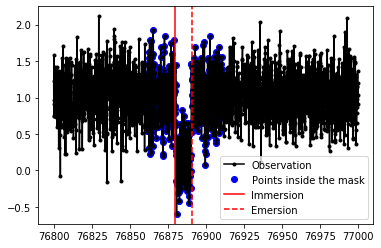

In [37]:
pl.plot(lc_1a.time,lc_1a.flux,'k.-',zorder=1,label='Observation')
pl.plot(lc_1a.time[mask],lc_1a.flux[mask],'bo',zorder=0,label='Points inside the mask')
pl.axvline(immersion_time,color='r',linestyle='-',label='Immersion')
pl.axvline(emersion_time,color='r',linestyle='--',label='Emersion')
pl.legend()
pl.show()

**Now, let's create the model**

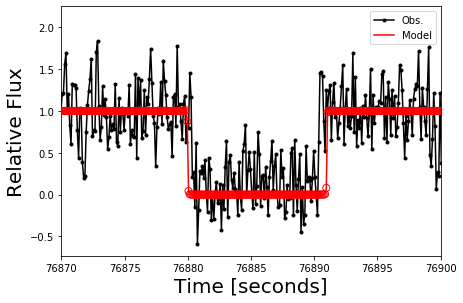

In [38]:
lc_1a.occ_model(immersion_time, emersion_time, opacity, mask)

lc_1a.plot_lc()
pl.xlim(76870,76900)
pl.show()

**Let's start with the fitting procedure**

In [39]:
lc_1a.occ_lcfit?

<a id="section_5a"></a>
#### 5.1. Automatic mode

This step is one of the most time consuming processes within the SORA package. It is expected that it would take between 1-10 minutes to complete 10000 loops. To spend less computational time with this tutorial, we will use only 1000 loops. However it is suggested that the user always set at least 10000 loops.

In [40]:
lc_chi2 = lc_1a.occ_lcfit(loop=1000)

**The result of the fitting is a ChiSquare Object**

That is an auxiliary object class, and its main information can be found at its specific Jupyter-Notebook, for the purpose of this tutorial only two main functions will be cover: _print(ChiSquare)_ and _ChiSquare.plot_chi()_.

In [41]:
print(lc_chi2)

Minimum chi-square: 489.942
Number of fitted points: 496
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 0.992

immersion:
    1-sigma: 76880.335 +/- 0.013
    3-sigma: 76880.366 +/- 0.135

emersion:
    1-sigma: 76890.341 +/- 0.020
    3-sigma: 76890.332 +/- 0.102



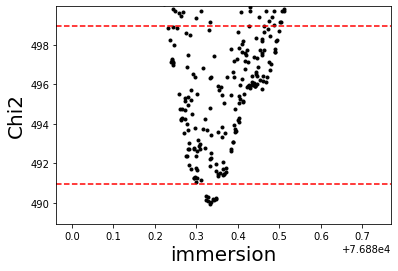

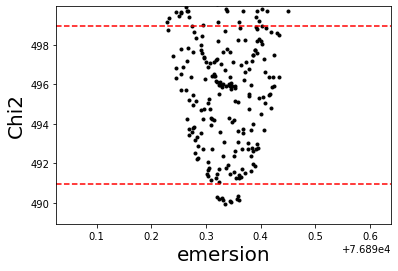

In [42]:
lc_chi2.plot_chi2()

**These gaps within the chisquare curve are expected as we did a small number of loops (1000)**

<a id="section_5b"></a>
#### 5.2. Fitting only the immersion

The user can set the parameters of choice to the fitting. That will allow using a more complex set of parameters for the model or do specific fits. One typical example is fitting one side of the chord (only the immersion time, for instance).

In [43]:
immersion_time = 76880.338 
tmin = 76873.000
tmax = 76887.000

mask = (lc_1b.time > tmin) & (lc_1b.time < tmax)

**Let's give a look at the parameters we created (visual aid)**

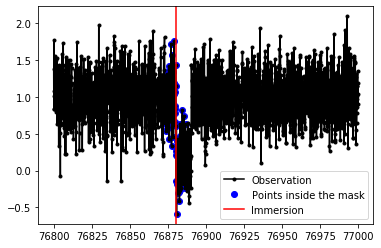

In [44]:
pl.plot(lc_1b.time,lc_1b.flux,'k.-',zorder=1,label='Observation')
pl.plot(lc_1b.time[mask],lc_1b.flux[mask],'bo',zorder=0,label='Points inside the mask')
pl.axvline(immersion_time,color='r',linestyle='-',label='Immersion')
pl.legend()
pl.show()

In [45]:
lc_chi2_1b_imm = lc_1b.occ_lcfit(tmin=tmin, tmax=tmax, immersion_time=immersion_time, 
                              delta_t=0.5, loop=1000)

In [46]:
print(lc_chi2_1b_imm)

Minimum chi-square: 154.491
Number of fitted points: 140
Number of fitted parameters: 1
Minimum chi-square per degree of freedom: 1.111

immersion:
    1-sigma: 76880.332 +/- 0.029
    3-sigma: 76880.361 +/- 0.121



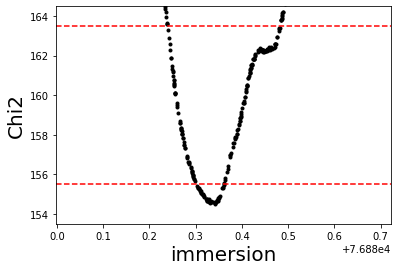

In [47]:
lc_chi2_1b_imm.plot_chi2()

<a id="section_5c"></a>
#### 5.3. Fitting the times and the opacity

Let's give a look in another LightCurve.


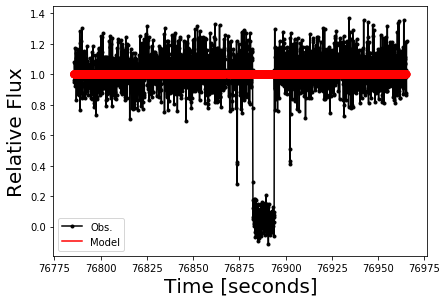

In [48]:
lc_2a.plot_lc()

**In this light curve, aside the occultation by the main body there are two secondary events (rings), now let's determine the times and the opacity for the first detection.**

In [49]:
lc_chi2_2a_ring = lc_2a.occ_lcfit(tmin=76872.676, tmax=76874.892, immersion_time=76873.676,
                                  emersion_time=76873.892, opacity=0.5, delta_t=0.1, 
                                  dopacity=0.5, loop=10000)

In [50]:
print(lc_chi2_2a_ring)

Minimum chi-square: 29.444
Number of fitted points: 27
Number of fitted parameters: 3
Minimum chi-square per degree of freedom: 1.227

immersion:
    1-sigma: 76873.673 +/- 0.011
    3-sigma: 76873.672 +/- 0.030

emersion:
    1-sigma: 76873.890 +/- 0.011
    3-sigma: 76873.893 +/- 0.033

opacity:
    1-sigma: 0.475 +/- 0.067
    3-sigma: 0.512 +/- 0.227



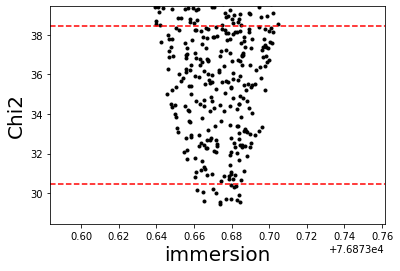

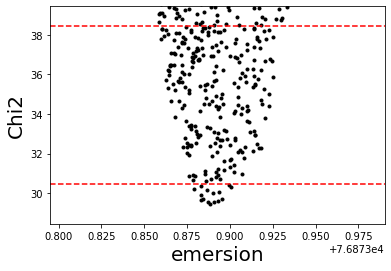

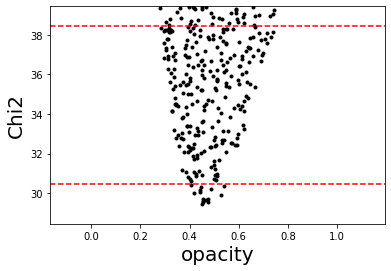

In [51]:
lc_chi2_2a_ring.plot_chi2()

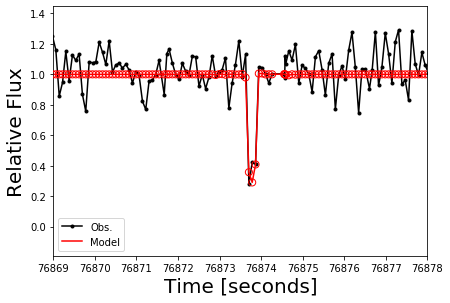

In [52]:
lc_2a.plot_lc()
pl.xlim(76869,76878)
pl.legend()
pl.show()

<a id="section_6"></a>
### 6. Viewing and saving the results


At the end, the immersion and emersion times can be easily accessed using _LightCurve.immersion_ and _LightCurve.emersion_. Their uncertainties can be found at _LightCurve.immersion_err_ and _LightCurve.emersion_err_. Plot functions were created to facilitate the user to created the desired plots, an automatic plot can be created using _Light_curve.plot_lc()_ and _LightCurve.plot_model()_, and the user can control the plot parameter using matplotlib functions. These plots can be saved using _matplotlib.pyplot.savefig()_.

In [53]:
print('Imersion time {} UTC'.format(lc_1a.immersion))
print('Imersion time err: {:.3f} seconds'.format(lc_1a.immersion_err))
print('\n')
print('Emersion time {} UTC'.format(lc_1a.emersion))
print('Emersion time err: {:.3f} seconds'.format(lc_1a.emersion_err))

Imersion time 2017-06-22 21:21:20.335 UTC
Imersion time err: 0.013 seconds


Emersion time 2017-06-22 21:21:30.341 UTC
Emersion time err: 0.020 seconds


**A complete log can be created by printing the LightCurve**

In [54]:
print(lc_1a)

Light curve name: Example 1a
Initial time: 2017-06-22 21:20:00.056 UTC
End time:     2017-06-22 21:23:19.958 UTC
Duration:     3.332 minutes
Time offset:  0.000 seconds

Exposure time:    0.1000 seconds
Cycle time:       0.1002 seconds
Num. data points: 2000

Bandwidth:            0.700 +/- 0.300 microns
Used shadow velocity: 22.000 km/s
Fresnel scale:        0.040 seconds or 0.88 km
Stellar size effect:  0.009 seconds or 0.20 km
Inst. response:       0.100 seconds or 2.20 km
Dead time effect:     0.000 seconds or 0.00 km
Model resolution:     0.004 seconds or 0.09 km
Modelled baseflux:    1.000
Modelled bottomflux:  0.000
Light curve sigma:    0.336

Immersion time: 2017-06-22 21:21:20.335 UTC +/- 0.013 seconds
Emersion time:  2017-06-22 21:21:30.341 UTC +/- 0.020 seconds

Monte Carlo chi square fit.

Minimum chi-square: 489.942
Number of fitted points: 496
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 0.992

immersion:
    1-sigma: 76880.335 +/- 0.013
    3

**And this log can be saved as a file using LightCurve.to_log()**

In [55]:
lc_1a.to_log('output/LC_test_1a.log')

!ls output/*.log

output/LC_test_1a.log  output/Test_occ.log


**The post fitted light curve can be plotted using the _LightCurve.plot_lc()_**

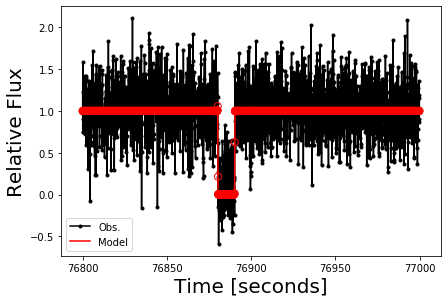

In [56]:
lc_1a.plot_lc()

**The post fitted light curve complete model can be plotted using the _LightCurve.plot_model()_**

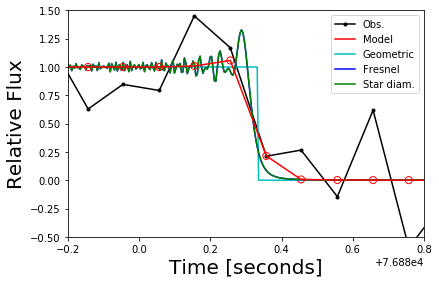

In [57]:
lc_1a.plot_lc()
lc_1a.plot_model()

pl.xlim(76879.8,76880.8)
pl.ylim(-0.5,1.5)

pl.show()

**The LightCurves data values can be saved using _LightCurve.to_file()_**

If the model was correctly fitted with SORA, 4 files should be created: (i) One containing the observational light curve and its convoluted model; (ii) Containing the complete light curve model (geometric, affected by fresnel diffraction and by the star apparent diameter); and (iii and iv) with the labels for each colunm for other two files. Otherwise only 2 files will be created: the observational one and its labels.

In [58]:
lc_1a.to_file?

In [59]:
lc_1a.to_file(namefile='output/LC_test_1a.dat')

!ls output/*.dat

!ls output/*.dat.label

output/example_chi2.dat  output/LOG.dat
output/LC_test_1a.dat	 output/model_LC_test_1a.dat
output/example_chi2.dat.label  output/model_LC_test_1a.dat.label
output/LC_test_1a.dat.label


**One last thing, a common issue within the Stellar occultation light curves is a time offset for a specific light curve**


To fit the body size and shape the user should consider the times (immersion and emersion) for all the observers. It is not unusual to have the different chords projected at the sky plane not be appropriately 'aligned'. Those shifts are often caused by instrumental issues (lack of GPS, software's features, internet protocols, among many others). To deal with this issue, the user can add a time offset (in seconds) manually at the LightCurve Object using the _LightCurve.dt_. Then the SORA package will automatically consider this offset to the fitted (or instantiated) parameters.

In [60]:
lc_1a.dt = 0 #seconds

print('Imersion time {} UTC'.format(lc_1a.immersion))

lc_1a.dt = 30 #seconds

print('Imersion time {} UTC'.format(lc_1a.immersion))

Imersion time 2017-06-22 21:21:20.335 UTC
Imersion time 2017-06-22 21:21:50.335 UTC


**This Jupyter-Notebook was designed as a tutorial for how to work with the LightCurve Object Class. More information about the other classes, please refer to their specif Jupyter-Notebook. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.**

# The End

